# Random Forest Classifier

### The Wisdom of Crowds
Imagine asking 100 people to guess the number of jellybeans in a jar. Individual guesses might be way off, but the **average** of all guesses is usually scary accurate.

**Random Forest** uses this same logic. It builds **100s of Decision Trees** and lets them vote. 

### How it works (Bagging)
1.  **Bootstrap:** Each tree gets a random subset of the data (with replacement). This makes each tree different.
2.  **Random Features:** At each split, the tree is allowed to look at only a random subset of features. This ensures the trees don't all look the same (correlation).
3.  **Aggregating:** For classification, we take the **Majority Vote** of all trees.

## Load Dataset (Heart Disease)
We'll use the Cleveland Heart Disease dataset to predict if a patient has heart disease.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import urllib.request

# Download Heart Disease Dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
data_path = "heart_disease.csv"

if not os.path.exists(data_path):
    urllib.request.urlretrieve(url, data_path)

# Define columns (UCI dataset doesn't have headers)
cols = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

df = pd.read_csv(data_path, names=cols, na_values='?')

# Simple Preprocessing
# Drop rows with missing values (ca and thal have a few)
df = df.dropna()

# Convert target to Binary (0 = No Disease, 1,2,3,4 = Disease)
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (297, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


### Algorithm : 

For B trees:

For each tree b = 1 . . . B: 

1. Draw bootstrap sample S
	​
2. Grow a decision tree:
	- At each node:
		- Randomly select m features
		- Choose best split using Gini / Entropy
	- Grow fully (usually no pruning)

3. Make Prediction - Mode for Classification, Mean for Regression

## The Showdown: Single Tree vs. Random Forest
Let's split the data and train both models to see which performs better.

Key Hyperparameters:
- n_estimators: Number of trees
- max_features: m features per split
- max_depth: Tree depth
- min_samples_leaf: Leaf size
- bootstrap: On/off

In [3]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Single Decision Tree
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
pred_tree = tree.predict(X_test)

# 2. Random Forest (100 Trees)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

print(f"Single Decision Tree Accuracy: {accuracy_score(y_test, pred_tree):.4f}")
print(f"Random Forest Accuracy:        {accuracy_score(y_test, pred_rf):.4f}")

Single Decision Tree Accuracy: 0.7833
Random Forest Accuracy:        0.8833


## Randomness - the two sources (core idea)

### (A) Bootstrapping (row sampling)

Given dataset of size N:
- Sample N points with replacement
- Some points appear multiple times
- ~63.2% unique samples per tree (important!)

Math intuition:
$$P(\text{a sample is NOT chosen}) = \left(1 - \frac{1}{N}\right)^N \approx e^{-1} \approx 0.368$$

So : 63.2% of data appears in each tree

### (B) Feature subsampling (column sampling)

At each split:
- Choose m random features out of d
- Find best split only among those

Typical choices:
- Classification: ​$m = \sqrt{d}$
- Regression: $m = \frac{d}{3}$

This decorrelates trees



## Feature Importance
Random Forest is amazing because it can tell us **which features matter most**.

*Does Cholesterol matter more than Max Heart Rate? Let's ask the model.*

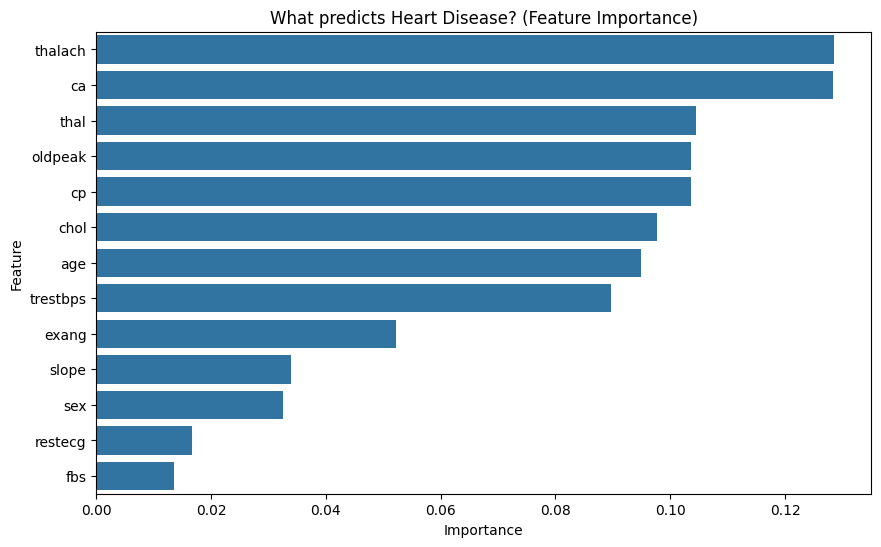

In [4]:
importances = rf.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df)
plt.title("What predicts Heart Disease? (Feature Importance)")
plt.show()

Idea behind Random Forest - “Train many different decision trees and average them.”

This reduces variance without increasing bias much.

## Out-of-Bag Error (OOB) 
- OOB samples are training points not included in a tree’s bootstrap sample (~36.8% per tree).
- Prediction: Each point is predicted using only the trees that didn’t see it.
- Error estimate: OOB error is the misclassification rate (classification) or MSE (regression) over all points using their OOB predictions.
- Purpose: Serves as a built-in validation to estimate generalization error without a separate test set.
- Extra use: OOB samples are also used for feature importance via permutation tests.